In [32]:
import numpy as np  # Importing the NumPy library for numerical operations and handling arrays
import matplotlib.pyplot as plt  # Importing the Pyplot module from Matplotlib for plotting and visualizations
import pandas as pd
import seaborn as sns
from scipy.spatial import KDTree

In [261]:
rho = 8e-6 #material density
Young_modulus = 19578.55  # Everything in kg and mm
nu = 0.3 #Poisson's Ratio
K = Young_modulus/(3.0*(1-2.0*nu))
horizon = 1.6
s0 = 0.02
total_time = 15
del_T = .1
time_steps = int(total_time/del_T)

In [277]:
bar_length = 15
number_of_elements = 7
nx = number_of_elements
ny = 1
delta_x = bar_length / number_of_elements
bulk_modulus = 100
nodes = np.linspace(-bar_length/2.0, bar_length/2.0, number_of_elements)
nodes_coords = np.column_stack((nodes, np.ones_like(nodes))) 
horizon = delta_x * 3.014
vol = 1 #Assumption

In [278]:
lengths = (nodes[1:] - nodes[0:-1])
lengths

array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5])

In [279]:
nodes_coords

array([[-7.5,  1. ],
       [-5. ,  1. ],
       [-2.5,  1. ],
       [ 0. ,  1. ],
       [ 2.5,  1. ],
       [ 5. ,  1. ],
       [ 7.5,  1. ]])

In [280]:
tree= KDTree(nodes_coords)

neighbors_within_horizons = tree.query_ball_tree(tree, horizon)

neighbors_within_horizons

[[0, 1, 2],
 [0, 1, 2, 3],
 [0, 1, 2, 3, 4],
 [1, 2, 3, 4, 5],
 [2, 3, 4, 5, 6],
 [3, 4, 5, 6],
 [4, 5, 6]]

In [281]:
ids = np.arange(len(nodes))

nodes_with_ids = np.column_stack((ids, nodes_coords))

nodes_with_ids

array([[ 0. , -7.5,  1. ],
       [ 1. , -5. ,  1. ],
       [ 2. , -2.5,  1. ],
       [ 3. ,  0. ,  1. ],
       [ 4. ,  2.5,  1. ],
       [ 5. ,  5. ,  1. ],
       [ 6. ,  7.5,  1. ]])

In [282]:
#practice to access the coords of the neighboring nodes of node 1

#Let
node_index = 0
neighbor_ids = tree.query_ball_point(nodes_coords[node_index], horizon)
neighbor_nodes = nodes_with_ids[neighbor_ids]

neighbor_nodes

array([[ 0. , -7.5,  1. ],
       [ 1. , -5. ,  1. ],
       [ 2. , -2.5,  1. ]])

In [283]:
"""
    velocity is given as boundary condition, therefore, convert it to displacement first.
"""
u_applied_05 = np.linspace(2e-2,2e-2,time_steps//3)
u_applied_510 = np.linspace(-2e-2,-2e-2,time_steps//3)
u_applied_1015 = np.linspace(0,0,time_steps//3)
u_applied = np.concatenate((u_applied_05, u_applied_510, u_applied_1015))
print(u_applied)

[ 0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02  0.02
  0.02  0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02 -0.02
 -0.02 -0.02 -0.02 -0.02  0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.  ]


In [284]:
u_vector_solution = np.zeros((time_steps, nx, ny))
print("Shape for u_vector_solution: ", u_vector_solution.shape)

u_vector_at_current_time_step = np.zeros((nx, ny))
print("Shape for u_vector_at_current_time_step: ", u_vector_at_current_time_step.shape)

u_vector_at_future_time_step = np.zeros((nx, ny))

u_vector_at_previous_time_step = np.zeros((nx, ny))

for n in range(0, time_steps):

    time_elapsed = n * del_T

    #print("Time elapsed: ", time_elapsed)
    
    # select the start and end position for the nodes based on the horizon
    start_position = -bar_length/2.0
    end_position = bar_length/2.0

    node_values = np.zeros((nx, ny))
    
    for i in range(len(nodes)):
        if abs(nodes[i] - start_position) <= horizon or abs(nodes[i] - end_position) <= horizon:
            node_values[i, 0] = u_applied[n]
    
    for x in range(nx):
        for y in range(ny):

            sum_term = 0
            
            # xi = value of the node at ith location
            xi = node_values[x][y]
            xi_index = int(nodes_with_ids[x][0])
            
            # get value of the node at ith location
            xi_locx = nodes_coords[x][0]
            xi_locy = nodes_coords[x][1]

            """
            We got the values for the ith nodes. Now fetch x_p nodes and use them in the equation of motion
            """

            # First find the neighboring nodes for the node at ith location
            node_index = int(nodes_with_ids[x][0])
            neighbor_ids = tree.query_ball_point(nodes_coords[node_index], horizon)
            #neighbor_nodes = nodes_with_ids[neighbor_ids]

            for p in range(len(neighbor_ids)):
                xp_locx = int(nodes_coords[p][0])
                xp_locy = int(nodes_coords[p][1])
                xp_index = int(nodes_with_ids[p][0])
                xp = node_values[xp_index]
                xp_index = int(nodes_with_ids[p][0])
                if xp_index == xi_index:
                    continue
                ksi = np.sqrt((xp_locx-xi_locx)**2 + (xp_locy-xi_locy)**2)

                eta = xp - xi

                c = (18*K)/(np.pi * horizon**4)

                s = ((np.abs(ksi+eta)) - np.abs(ksi))/np.abs(ksi)

                if s > s0:
                    mu = 0
                else:
                    mu = 1    
                
                sum_term = sum_term + ((((ksi+eta)/np.abs(ksi+eta)) * c * s * mu)*vol) #+ 9.8e-9 #(body force = 9.8 m/s^2)
                #print(sum_term)

                acceleration = sum_term/rho

        u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]

        u_vector_solution[n, x, y] = u_vector_at_current_time_step[x, y]

    u_vector_at_previous_time_step = u_vector_at_current_time_step.copy()
    u_vector_at_current_time_step = u_vector_at_future_time_step.copy()


Shape for u_vector_solution:  (150, 7, 1)
Shape for u_vector_at_current_time_step:  (7, 1)


C:\Users\st35345\AppData\Local\Temp/ipykernel_63272/3595275137.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_vector_at_future_time_step[x,y] = (acceleration*del_T**2) + (2*u_vector_at_current_time_step[x,y]) - u_vector_at_previous_time_step[x, y]


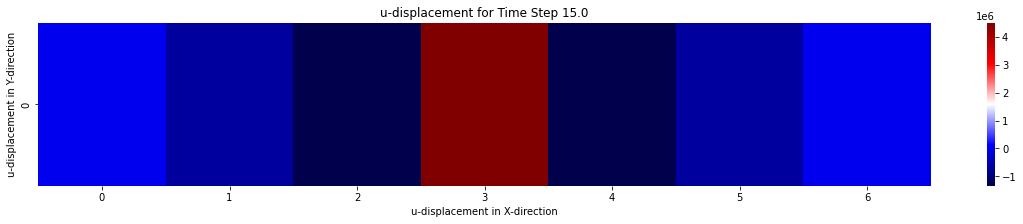

In [290]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

# Assuming 'array' is your data with shape (30, 50, 50)
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(20, 3))

# Find the min and max values in the data for consistent scaling
vmin = np.min(u_vector_solution)
vmax = np.max(u_vector_solution)

# Initialize the heatmap with the first timestep
heatmap = sns.heatmap(u_vector_solution[0, :, :].reshape(1, -1), cmap='seismic', ax=ax, vmin=vmin, vmax=vmax)
plt.title('Heatmap of u-displacement Over Time')
plt.xlabel('u-displacement in X-direction')
plt.ylabel('u-displacement in Y-direction')

# Function to update the heatmap for each frame in the animation
def update(frame):
    ax.clear()
    heatmap = sns.heatmap(u_vector_solution[frame, :, :].reshape(1, -1), cmap='seismic', ax=ax, vmin=vmin, vmax=vmax, cbar=False)
    ax.set_title(f'u-displacement for Time Step {(frame + 1)/10}')
    ax.set_xlabel('u-displacement in X-direction')
    ax.set_ylabel('u-displacement in Y-direction')

# Create the animation
anim = FuncAnimation(fig, update, frames=u_vector_solution.shape[0], interval=200)

# Save the animation as a GIF
anim.save('animation1.gif', writer=PillowWriter(fps=5))

# Alternatively, display the animation
plt.show()